In [434]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ipywidgets import interact
from sympy import *
from utils.fehler_gauss import *
from scipy import constants
from scipy.optimize import curve_fit

# Unsicherheiten
u_U = 0.5e3
u_I = 20e-6
u_beta_anleitung = np.deg2rad(0.05)
a_nacl = 564.02e-12
d_nacl = a_nacl / 2

# Sheets einlesen
sheet_names = [
    "NaCl",
    "Zirkoniumfolie",
    "NaCl gedreht",
    "LiF",
    "Variation Ströme bei LiF",
    "Variation Spannung bei LiF",
]
dfs = {}
for sheet_name in sheet_names:
    dfs[sheet_name] = pd.read_excel("XST.xlsx", sheet_name=sheet_name)

## Winkelunsicherheit

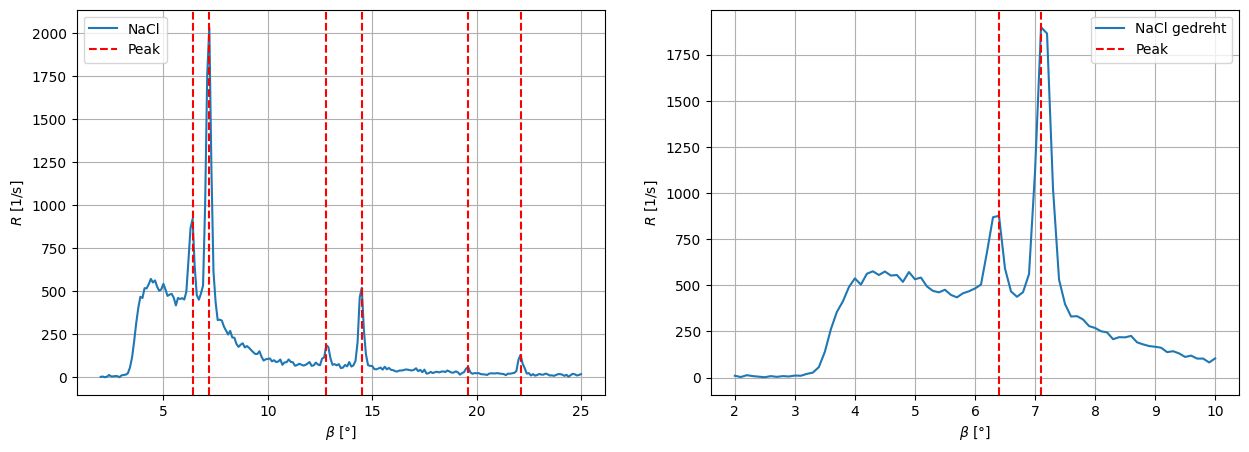

In [435]:
# NaCl Daten
nacl = dfs["NaCl"]
nacl.columns = ["beta", "R"]

# Wiederholungsmessung NaCl
nacl_gedreht = dfs["NaCl gedreht"]
nacl_gedreht.columns = ["beta", "R"]

# Plot erstellen
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# Messungen plotten
nacl.plot(x="beta", y="R", kind="line", grid=True, ax=axs[0])
axs[0].set_xlabel(r"$\beta$ [°]")
axs[0].set_ylabel(r"$R$ [1/s]")
nacl_gedreht.plot(x="beta", y="R", kind="line", grid=True, ax=axs[1])
axs[1].set_xlabel(r"$\beta$ [°]")
axs[1].set_ylabel(r"$R$ [1/s]")

# peaks identifizieren
peaks_idcs_nacl = [44, 52, 108, 125, 176, 201]
peaks_idcs_nacl_gedreht = [44, 51]

# Peaks plotten
for peak_idx in peaks_idcs_nacl:
    axs[0].axvline(x=nacl["beta"][peak_idx], color="red", linestyle="--", label="Peak")
for peak_idx in peaks_idcs_nacl_gedreht:
    axs[1].axvline(x=nacl_gedreht["beta"][peak_idx], color="red", linestyle="--", label="Peak")

axs[0].legend(["NaCl", "Peak"])
axs[1].legend(["NaCl gedreht", "Peak"])

plt.savefig("Winkelunsicherheit.svg")

In [436]:
# winkeldifferenzen zwischen den beiden linken peaks berechnen
nacl_peaks_beta = nacl["beta"][peaks_idcs_nacl].values
nacl_gedreht_peaks_beta = nacl_gedreht["beta"][peaks_idcs_nacl_gedreht].values
diffs = np.abs(nacl_peaks_beta[:2] - nacl_gedreht_peaks_beta)
diffs_rad = np.deg2rad(diffs)

# Gesamtunsicherheit aus winkeldifferenzen und anleitung berechnen
u_beta = np.sqrt(u_beta_anleitung**2 + diffs_rad.max()**2)
print(f"u_beta = {u_beta} rad", " = ", np.rad2deg(u_beta), "°")

u_beta = 0.0019513374252890991 rad  =  0.11180339887498997 °


## Emissionsspektrum der Molybdän-Röntgenröhre

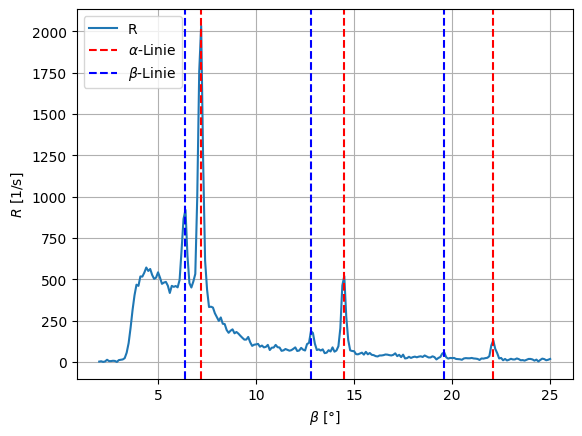

In [437]:
nacl.plot(x="beta", y="R", kind="line", grid=True)
plt.xlabel(r"$\beta$ [°]")
plt.ylabel(r"$R$ [1/s]")

# alpha peaks plotten (jeder 2.)
alpha_peak_idcs = peaks_idcs_nacl[1::2]
for i, peak_idx in enumerate(alpha_peak_idcs):
    label = "" if i > 0 else r"$\alpha$-Linie"
    plt.axvline(x=nacl["beta"][peak_idx], color="red", linestyle="--", label=label)

# beta peaks plotten (jeder 2.)
beta_peak_idcs = peaks_idcs_nacl[::2]
for i, peak_idx in enumerate(beta_peak_idcs):
    label = "" if i > 0 else r"$\beta$-Linie"
    plt.axvline(x=nacl["beta"][peak_idx], color="blue", linestyle="--", label=label)

plt.legend()

plt.savefig("Spektrum_Molybdaen.svg")

In [438]:
# Bragg Bedingung
n_symbol, d_symbol, beta_symbol, lambda_symbol = symbols("n d beta lambda")
bragg_bedingung = Eq(2 * d_symbol * sin(beta_symbol), n_symbol*lambda_symbol)
bragg_bedingung

Eq(2*d*sin(beta), lambda*n)

In [439]:
lambda_formula = solve(bragg_bedingung, lambda_symbol)[0]
lambda_formula

2*d*sin(beta)/n

In [440]:
# Wellenlängen berechnen
alpha_peak_betas = nacl["beta"][alpha_peak_idcs].values
beta_peak_betas = nacl["beta"][beta_peak_idcs].values

alpha_lambda_vals, u_alpha_lambda_vals = fehler_gauss(
    lambda_formula,
    [beta_symbol, d_symbol, n_symbol],
    [np.deg2rad(alpha_peak_betas), d_nacl, np.array([1, 2, 3])],
    [u_beta, 0, 0],
)

beta_lambda_vals, u_beta_lambda_vals = fehler_gauss(
    lambda_formula,
    [beta_symbol, d_symbol, n_symbol],
    [np.deg2rad(beta_peak_betas), d_nacl, np.array([1, 2, 3])],
    [u_beta, 0, 0],
)

In [441]:
# Energien berechnen
h_symbol, c_symbol, lambda_symbol = symbols("h c lambda")
E_formula = h_symbol*c_symbol/lambda_symbol
E_formula

c*h/lambda

In [442]:
e_alphas, u_e_alphas = fehler_gauss(
    E_formula,
    [h_symbol, c_symbol, lambda_symbol],
    [constants.h, constants.c, alpha_lambda_vals],
    [0, 0, u_alpha_lambda_vals],
)
e_alphas = e_alphas / constants.e
u_e_alphas = u_e_alphas / constants.e

e_betas, u_e_betas = fehler_gauss(
    E_formula,
    [h_symbol, c_symbol, lambda_symbol],
    [constants.h, constants.c, beta_lambda_vals],
    [0, 0, u_beta_lambda_vals],
)
e_betas = e_betas / constants.e
u_e_betas = u_e_betas / constants.e

In [443]:
alpha_linien_preview = pd.DataFrame(
    {
        "n": [1, 2, 3],
        r"$\beta$ [$\unit{\degree}$]": alpha_peak_betas,
        r"$\lambda$ [$\unit{m}$]": format_result(
            alpha_lambda_vals, u_alpha_lambda_vals, [11, 11, 11], [2, 2, 2], r"\meter"
        ),
        r"$E$ [$\unit{\kilo\electronvolt}$]": format_result(
            e_alphas * 1e-3, u_e_alphas * 1e-3, [0, 0, 0], [2, 2, 2], r""
        ),
    }
)
print(
    alpha_linien_preview.to_latex(
        index=False,
        float_format="%.2f",
    )
)

\begin{tabular}{rrll}
\toprule
n & $\beta$ [$\unit{\degree}$] & $\lambda$ [$\unit{m}$] & $E$ [$\unit{\kilo\electronvolt}$] \\
\midrule
1 & 7.20 & \SI{7.07(11)e-11}{\meter} & \SI{17.54(27)e0}{} \\
2 & 14.50 & \SI{7.06(05)e-11}{\meter} & \SI{17.56(13)e0}{} \\
3 & 22.10 & \SI{7.07(03)e-11}{\meter} & \SI{17.53(08)e0}{} \\
\bottomrule
\end{tabular}



In [444]:
beta_linien_preview = pd.DataFrame(
    {
        "n": [1, 2, 3],
        r"$\beta$ [$\unit{\degree}$]": beta_peak_betas,
        r"$\lambda$ [$\unit{m}$]": format_result(
            beta_lambda_vals, u_beta_lambda_vals, [11, 11, 11], [2, 2, 2], r"\meter"
        ),
        r"$E$ [$\unit{\kilo\electronvolt}$]": format_result(
            e_betas * 1e-3, u_e_betas * 1e-3, [0, 0, 0], [2, 2, 2], r""
        ),
    }
)
print(
    beta_linien_preview.to_latex(
        index=False,
        float_format="%.1f",
    )
)

\begin{tabular}{rrll}
\toprule
n & $\beta$ [$\unit{\degree}$] & $\lambda$ [$\unit{m}$] & $E$ [$\unit{\kilo\electronvolt}$] \\
\midrule
1 & 6.4 & \SI{6.29(11)e-11}{\meter} & \SI{19.72(34)e0}{} \\
2 & 12.8 & \SI{6.25(05)e-11}{\meter} & \SI{19.84(17)e0}{} \\
3 & 19.6 & \SI{6.31(03)e-11}{\meter} & \SI{19.66(11)e0}{} \\
\bottomrule
\end{tabular}



In [445]:
# Gewichtete Mittelwerte der Wellenlängen
alpha_lambda, u_alpha_lambda = weighted_mean(alpha_lambda_vals, u_alpha_lambda_vals)
print(f"Wellenlänge Alpha-Linie: {alpha_lambda} ± {u_alpha_lambda} m")

beta_lambda, u_beta_lambda = weighted_mean(beta_lambda_vals, u_beta_lambda_vals)
print(f"Wellenlänge Beta-Linie: {beta_lambda} ± {u_beta_lambda} m")

# Gewichtete Mittelwerte der Energien
e_alpha, u_e_alpha = weighted_mean(e_alphas, u_e_alphas)
print(f"Energie Alpha-Linie: {e_alpha*1e-3} ± {u_e_alpha*1e-3} keV")

e_beta, u_e_beta = weighted_mean(e_betas, u_e_betas)
print(f"Energie Beta-Linie: {e_beta*1e-3} ± {u_e_beta*1e-3} keV")

Wellenlänge Alpha-Linie: 7.069665747358627e-11 ± 2.771700539003304e-13 m
Wellenlänge Beta-Linie: 6.289309040703057e-11 ± 2.808201440281178e-13 m
Energie Alpha-Linie: 17.537460218367745 ± 0.06875655746222502 keV
Energie Beta-Linie: 19.712486783470887 ± 0.08801702986306593 keV


## Absorption Zirkonium

In [446]:
zirc = dfs["Zirkoniumfolie"]
zirc.columns = ["beta", "R"]

nacl = nacl.set_index("beta")
zirc = zirc.set_index("beta")

nacl = nacl.loc[zirc.index]

data = pd.DataFrame({
    "beta": zirc.index,
    "R_NaCl": nacl["R"].values,
    "R_Zirkonium": zirc["R"].values
})
data["R_Zirkonium"] = data["R_Zirkonium"].shift(-2) # Zirkonium ausgleichen
data["Transmission"] = data["R_Zirkonium"] / data["R_NaCl"]
data = data.dropna()
data

,beta,R_NaCl,R_Zirkonium,Transmission
0,4.0,461,160.0,0.347072
1,4.1,518,135.0,0.260618
2,4.2,517,162.0,0.313346
3,4.3,541,161.0,0.297597
4,4.4,572,164.0,0.286713
5,4.5,551,170.0,0.308530
6,4.6,563,152.0,0.269982
7,4.7,527,141.0,0.267552
8,4.8,503,157.0,0.312127
9,4.9,511,141.0,0.275930


In [447]:
lambdas, u_lambdas = fehler_gauss(
    lambda_formula,
    [d_symbol, beta_symbol, n_symbol],
    [d_nacl, np.deg2rad(data["beta"].values), 1],
    [0, u_beta, 0],
)

data["lambda"] = lambdas
data["u_lambda"] = u_lambdas
data

,beta,R_NaCl,R_Zirkonium,Transmission,lambda,u_lambda
0,4.0,461,160.0,0.347072,3.934405e-11,1.097912e-12
1,4.1,518,135.0,0.260618,4.032599e-11,1.097777e-12
2,4.2,517,162.0,0.313346,4.130781e-11,1.097638e-12
3,4.3,541,161.0,0.297597,4.228950e-11,1.097495e-12
4,4.4,572,164.0,0.286713,4.327107e-11,1.097350e-12
5,4.5,551,170.0,0.308530,4.425250e-11,1.097201e-12
6,4.6,563,152.0,0.269982,4.523380e-11,1.097048e-12
7,4.7,527,141.0,0.267552,4.621496e-11,1.096892e-12
8,4.8,503,157.0,0.312127,4.719598e-11,1.096733e-12
9,4.9,511,141.0,0.275930,4.817685e-11,1.096571e-12


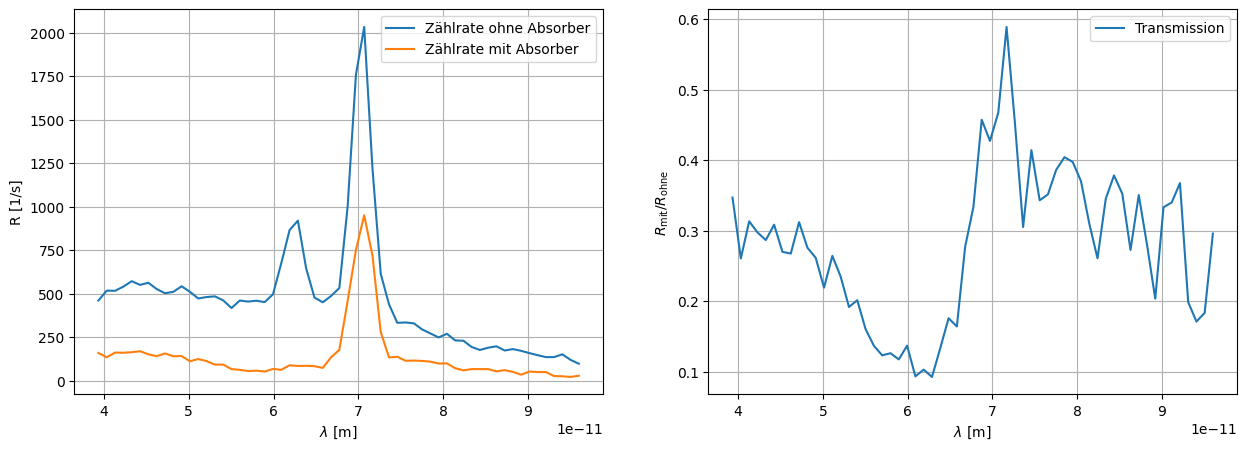

In [448]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

data.plot(x="lambda", y=["R_NaCl", "R_Zirkonium"], kind="line", grid=True, ax=axs[0])
axs[0].set_xlabel(r"$\lambda$ [m]")
axs[0].legend(["Zählrate ohne Absorber", "Zählrate mit Absorber"])
axs[0].set_ylabel("R [1/s]")

data.plot(x="lambda", y="Transmission", kind="line", grid=True, ax=axs[1])
axs[1].set_xlabel(r"$\lambda$ [m]")
axs[1].set_ylabel(r"$R_{\rm{mit}}$/$R_{\rm{ohne}}$")

plt.savefig("Transmission_Zirkonium.svg")

In [449]:
absorptionskante = data.sort_values(by="Transmission", ascending=False).iloc[0]
print(f"Wellenlänge Absorptionskante: {absorptionskante['lambda']} +- {absorptionskante['u_lambda']}")

# quantenenergie der absorptionskante
energie_abs_kante = constants.h * constants.c / absorptionskante["lambda"]
print(f"Energie Absorptionskante: {energie_abs_kante/constants.e * 1e-3} keV")

Wellenlänge Absorptionskante: 7.16669805433337e-11 +- 1.091672412152833e-12
Energie Absorptionskante: 17.300044943044973 keV


# Gitterzahl LiF

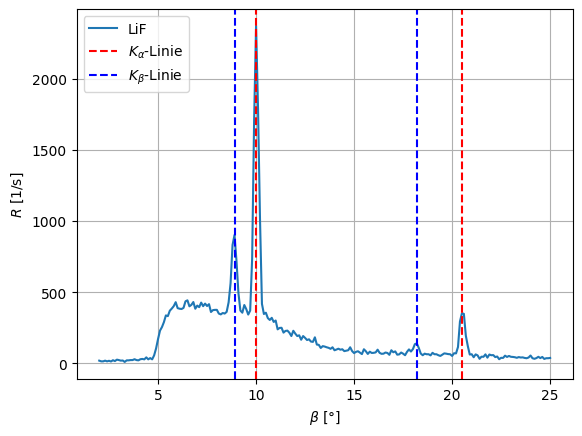

In [450]:
lif = dfs["LiF"]
lif.columns = ["beta", "R"]

# Das spektrum plotten
alphas = [80, 185]
betas = [69, 162]

lif.plot(x="beta", y="R", grid=True, label="LiF")

for i, alpha_idx in enumerate(alphas):
    label = r"$K_\alpha$-Linie" if i == 0 else ""
    plt.axvline(lif.loc[alpha_idx]["beta"], linestyle="--", c="r", label=label)

for i, beta_idx in enumerate(betas):
    label = r"$K_\beta$-Linie" if i == 0 else ""
    plt.axvline(lif.loc[beta_idx]["beta"], linestyle="--", c="b", label=label)

plt.xlabel(r"$\beta$ [°]")
plt.ylabel(r"$R$ [1/s]")
plt.legend()

plt.savefig("Spektrum_LiF.svg")

In [451]:
# Gitterabstand berechnen
d_formula = solve(bragg_bedingung, d_symbol)[0]
d_formula

lambda*n/(2*sin(beta))

In [452]:
alpha_ds, u_alpha_ds = fehler_gauss(
    d_formula,
    [lambda_symbol, n_symbol, beta_symbol],
    [alpha_lambda_vals[:2], np.array([1, 2]), np.deg2rad(lif.loc[alphas]["beta"].values)],
    [u_alpha_lambda_vals[:2], 0, u_beta]
)

beta_ds, u_beta_ds = fehler_gauss(
    d_formula,
    [lambda_symbol, n_symbol, beta_symbol],
    [beta_lambda_vals[:2], np.array([1, 2]), np.deg2rad(lif.loc[betas]["beta"].values)],
    [u_beta_lambda_vals[:2], 0, u_beta]
)

In [453]:
d_val, u_d_val = weighted_mean(
    np.concat((alpha_ds, beta_ds)),
    np.concat((u_alpha_ds, u_beta_ds))
)
print(f"Gitterkonstante LiF: {d_val} +- {u_d_val} m")
print(f"Netzebenenabstand a: {2*d_val} +- {2*u_d_val} m")

Gitterkonstante LiF: 2.013855632772971e-10 +- 1.248744393687644e-12 m
Netzebenenabstand a: 4.027711265545942e-10 +- 2.497488787375288e-12 m


## Detektortotzeit

tau: 8.046807730244563e-05 +- 1.3232707025894175e-05 s


/home/nico/AP3/env/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


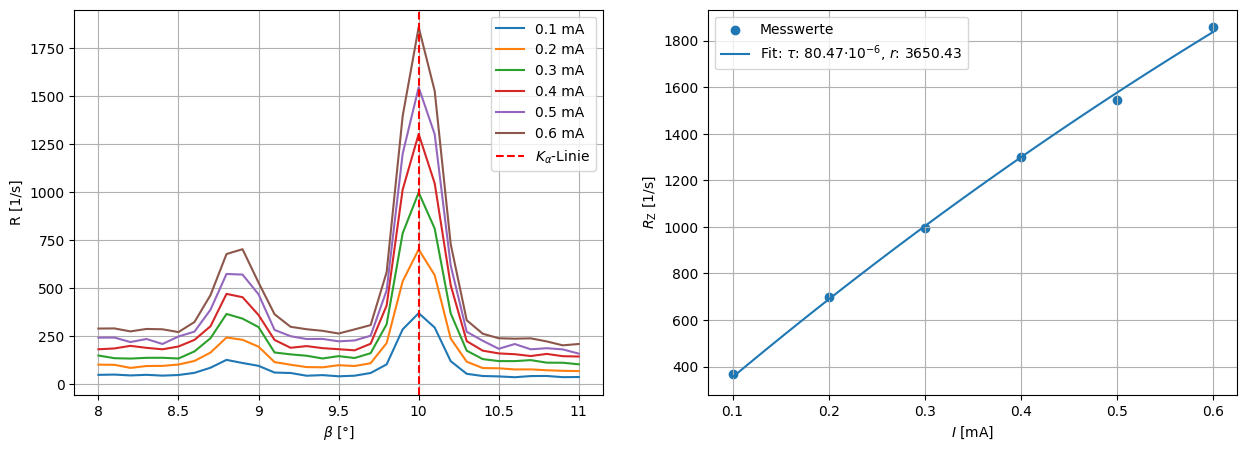

In [454]:
detektor_data = dfs["Variation Ströme bei LiF"]

messreihen = {}

R_maxima = {}

# messreihen einlesen
for i in range(6):
    messreihe = detektor_data[detektor_data.columns[1 + 2 * i : 1 + 2 * i + 2]].drop(
        index=0
    )
    strom = messreihe.columns[0]
    messreihe.columns = ["beta", "R"]
    R_maxima[strom] = messreihe.sort_values(by="R", ascending=False).iloc[0]["R"]
    messreihen[strom] = messreihe.dropna()
messreihen = pd.concat(messreihen).sort_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# messreihen plotten
for strom in messreihen.index.unique(0):
    messreihen.loc[strom].plot(x="beta", y="R", ax=axs[0], label=f"{strom} mA")

axs[0].set_xlabel(r"$\beta$ [°]")
axs[0].set_ylabel(r"R [1/s]")
axs[0].grid()
k_alpha_linie = 20
axs[0].axvline(k_alpha_linie, linestyle="--", c="r", label=r"$K_\alpha$-Linie")
axs[0].legend()


# Zaehlraten der Maxima gegen Strom fitten
def zaehlrate(strom, tau, r):
    return r * strom * np.exp(-r * tau * strom)


R_maxima = pd.Series(R_maxima)

popt, pcov = curve_fit(zaehlrate, R_maxima.index, R_maxima.values)

print(f"tau: {popt[0]} +- {np.sqrt(pcov[0, 0])}", "s")

X = np.linspace(R_maxima.index.min(), R_maxima.index.max(), 100)
Y = zaehlrate(X, *popt)

# Zaehlraten der K_alpha Linie gegen Strom plotten
axs[1].scatter(R_maxima.index, R_maxima, label="Messwerte")
axs[1].set_xlabel(r"$I$ [mA]")
axs[1].set_ylabel(r"$R_{\rm{Z}}$ [1/s]")

fit_label = r"Fit: $\tau$: {:.2f}".format(popt[0]*1e6) + r"$\cdot 10^{-6}$" + r", $r$: {:.2f}".format(popt[1])
axs[1].plot(X, Y, label=fit_label)
axs[1].grid()
axs[1].legend()

plt.savefig("Totzeit.svg")

## Plancksches Wirkungsquantum

In [455]:
planck_data = dfs["Variation Spannung bei LiF"]

messreihen = {}

for i in range(6):
    messreihe = planck_data[planck_data.columns[1 + 2 * i : 1 + 2 * i + 2]].drop(
        index=0
    )
    spannung = messreihe.columns[0][:2]
    messreihe.columns = ["beta", "R"]
    messreihen[spannung] = messreihe.dropna()

messreihen = pd.concat(messreihen).sort_index()
messreihen

beta      R
24 1   6.5   4.69
   2   6.6   6.38
   3   6.7   6.44
   4   6.8   5.94
   5   6.9    7.5
...    ...    ...
35 22  6.1  408.4
   23  6.2    416
   24  6.3  400.8
   25  6.4  421.8
   26  6.5  413.4

[151 rows x 2 columns]

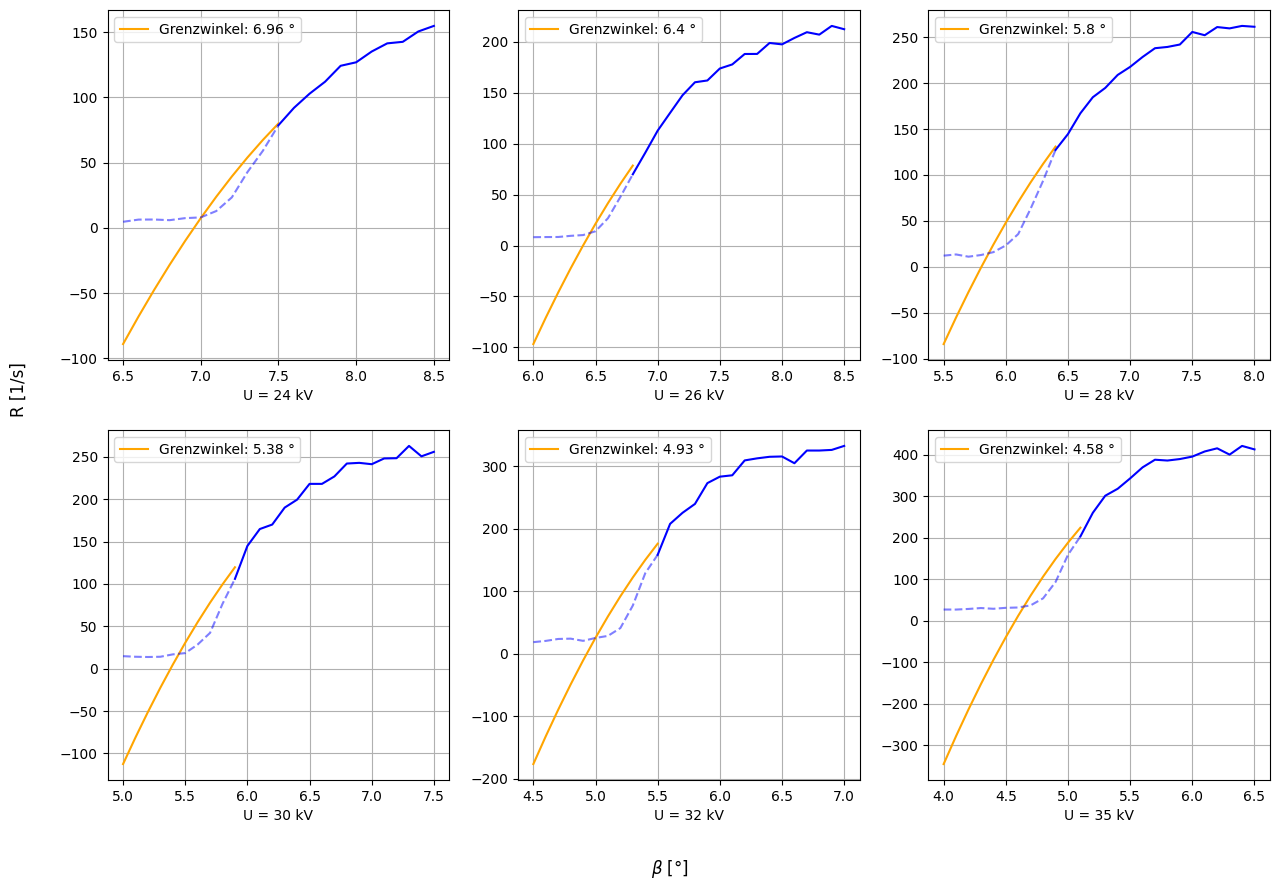

In [464]:
# Suche nach Grenzwellenlängen / Grenzwinkeln
spannungen = messreihen.index.unique(0)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
cutoff_idcs = [10, 8, 9, 9, 10, 11]

grenzwinkel = {}

for i, (spannung, cutoff_idx) in enumerate(zip(spannungen, cutoff_idcs)):
    messreihe = messreihen.loc[spannung]

    out_sample = messreihe.iloc[:cutoff_idx]
    in_sample = messreihe.iloc[cutoff_idx:]

    # Mit quadratischem Fit extrapolieren
    poly = np.polyfit(
        in_sample["beta"].values.astype(float), in_sample["R"].values.astype(float), 2
    )
    poly = np.poly1d(poly)
    axs[i].plot(
        messreihe.iloc[: cutoff_idx + 1]["beta"],
        poly(messreihe.iloc[: cutoff_idx + 1]["beta"]),
        c="orange",
        label=f"Grenzwinkel: {np.round(poly.roots[1], 2)} °"
    )
    grenzwinkel[spannung] = poly.roots[1]

    axs[i].plot(
        messreihe.iloc[: cutoff_idx + 1]["beta"],
        messreihe.iloc[: cutoff_idx + 1]["R"],
        linestyle="--",
        c="blue",
        alpha=0.5,
    )
    axs[i].plot(
        messreihe.iloc[cutoff_idx:]["beta"], messreihe.iloc[cutoff_idx:]["R"], c="blue"
    )
    axs[i].grid()
    axs[i].legend()
    axs[i].set_xlabel(r"U = " + spannung + " kV")

fig.supxlabel(r"$\beta$ [°]")
fig.supylabel(r"R [1/s]", x=0.06)

fig.savefig("planck_grenzwinkel.svg")

In [457]:
grenzwinkel = pd.Series(grenzwinkel)

In [458]:
e_symbol, U_symbol = symbols("e U")

lambda_0 = (h_symbol * c_symbol)/(e_symbol * U_symbol)
lambda_0

c*h/(U*e)

In [459]:
h_formula = solve(bragg_bedingung.subs(lambda_symbol, lambda_0), h_symbol)[0].subs(n_symbol, 1)
h_formula

2*U*d*e*sin(beta)/c

In [460]:
h_vals, u_h_vals = fehler_gauss(
    h_formula.subs({e_symbol: constants.e, c_symbol: constants.c}),
    [U_symbol, d_symbol, beta_symbol],
    [grenzwinkel.index.values.astype(float) * 1e3, d_val, np.deg2rad(grenzwinkel.values)],
    [u_U, u_d_val, np.sqrt(u_beta**2 + np.deg2rad(1)**2)] # normale Winkelunsicherheit + 1°
)

h_val, u_h_val = weighted_mean(h_vals, u_h_vals)
print(f"h = {h_val} +- {u_h_val}")

h = 6.122935428331448e-34 +- 4.40193249351427e-35
